In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_multilabel_classification
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import math
import collections
import pydotplus
from pydotplus.graphviz import Graph, Node, Edge
from IPython.display import Image
%matplotlib inline

计算熵:

$$
H = \sum_{i=1}^Nlog(p)*p
$$

In [2]:
def entropy(labels):
    labels = labels.flatten()
    vals = np.unique(labels)
    probs = [(labels==v).sum()/labels.size for v in vals]
    ans = -sum([np.log2(p)/p for p in probs])
    return ans

x = np.random.randint(1, 5, 20)
x, entropy(x)

(array([3, 3, 4, 3, 3, 1, 4, 3, 1, 1, 4, 4, 3, 2, 2, 4, 1, 3, 2, 2]),
 35.546632871244356)

计算特征A的条件熵，按照特征A划分为K类，每个类的熵乘以这个类所占的比例，再求和

$$
H(D|A) = \sum_{i=1}^K\frac{|D_i|}{|D|}H(D_i) = \sum_{i=1}^Np(D_i)H(D_i)
$$

In [3]:
def entropy_by_feature(X, y, feature_index):
    x = X.iloc[:, feature_index].values
    uniq_x = np.unique(x)
    ans = sum([(x==v).sum()/x.size * entropy(y.iloc[:, 0][x==v].values) for v in uniq_x])
    method = ['{}={}'.format(X.columns[feature_index], v) for v in uniq_x]
    
    def f(d, v):
        return d[d==v]
    
    filters = lambda data, fname, val, opindex: data[data[fname]==val]
    split_func = lambda data, findex: np.where(uniq_x==data[findex])[0][0]

    return ans, method, uniq_x, filters, split_func

In [4]:
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [5]:
data, columns = create_data()

df = pd.DataFrame(data, columns=columns)
df.head()

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否


In [6]:
[entropy_by_feature(df.iloc[:, :-1], df.iloc[:, [-1]], i)[:2] for i in range(df.shape[1]-1)], entropy(df.iloc[:, -1].values)


([(7.026081016012281, ['年龄=中年', '年龄=老年', '年龄=青年']),
  (3.0220641516636104, ['有工作=否', '有工作=是']),
  (3.379398751947122, ['有自己的房子=否', '有自己的房子=是']),
  (6.2569493656467525, ['信贷情况=一般', '信贷情况=好', '信贷情况=非常好'])],
 4.533096227495416)

In [7]:
class Id3TreeNode:
    def __init__(self, ):
        self.feature_index = 0
        self.feature_name = ''
        self.feature_val = None
        self.y = 0
        self.entropy = 0
        self.label = ''
        self.children = []
        self.sample_size = []
        self.split_method = ''
        self.feature_range = None
        self.percent = 0
        self.split_func = lambda x, fi: 0
    
    def predict(self, x):
        fi = self.feature_index
        i = self.split_func(x, fi)
        if self.children is not None and len(self.children) > i:
            return self.children[i].predict(x)
        return self.y
        

def build_id3(data, fv, enc_func, verbose=False, eps=0):
    if data.empty or data.shape[1] <= 1:
        return None
    
    node = Id3TreeNode()
    node.feature_val = fv
    
    y = data.iloc[:, -1]
    if np.unique(y).size == 1:
        node.y = y[0]
        node.sample_size = data.shape[0]
        node.feature_name = data.columns[0]
        node.label = '{}_{}'.format(node.y, fv)
        node.feature_range = [np.min(data[node.feature_name]), np.max(data[node.feature_name])]
        node.percent = 1.0
        
        return node

    node.entropy = entropy(y.values)
    ycount = y.value_counts().sort_values(ascending=False)
    node.y = ycount.index[0]
    node.percent = ycount.iloc[0]/y.size
    
    node.sample_size = data.shape[0]
    node.label = '{}_{}'.format(node.y, fv)
    # 计算信息增益，因为每个(条件熵-熵)再比较大小，和不减一样，所以直接比较条件熵
    es_m_v = [enc_func(data.iloc[:, :-1], data.iloc[:, [-1]], i) for i in range(data.shape[1]-1)]
    es = [v[0] for v in es_m_v]
    feature_index = np.argmin(es)
    feature_name = data.columns[feature_index]
    node.feature_name = feature_name
    node.feature_index = feature_index
    node.feature_range = [np.min(data[feature_name]), np.max(data[feature_name])]
    
    if es[feature_index] < eps:
        return node
    
    if verbose:
        print('='*40)
        print('split by {}'.format(feature_name))
        
    if data.shape[1] > 2: 
        children = []
        node.split_func = es_m_v[feature_index][4] 
        for iv, v in enumerate(es_m_v[feature_index][2]):
            d = es_m_v[feature_index][3](data, feature_name, v, iv).copy()
            d.reset_index(inplace=True, drop=True)
            d.drop(columns=[feature_name], inplace=True)
            if verbose:
                print(feature_name, v)
                print(d)
            if not d.empty:
                c = build_id3(d, v, enc_func)
                c.split_method = es_m_v[feature_index][1][iv]
                children.append(c)
            else:
                children.append(None)
        if verbose:
            print('='*40)
        node.children = children
    
    return node

tree = build_id3(df, 0, entropy_by_feature)

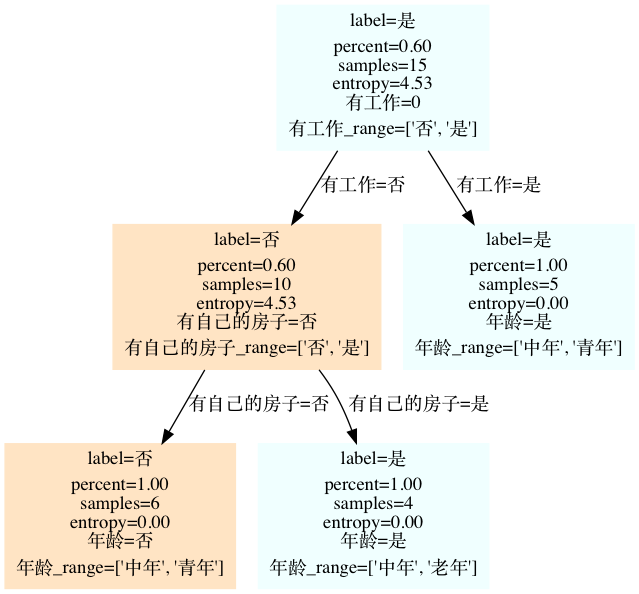

In [8]:
nodeindex = 0
edge_labels = {}
def plot_tree(tree, colors):

    # G = nx.DiGraph()

    G = Graph()
    # https://www.graphviz.org/doc/info/colors.html

    def build_graph(treeNode, colors):
        if treeNode is None:
            return

        global nodeindex
        global edge_labels

        nodeindex += 1
        currindex = nodeindex
        label = 'label={}\npercent={:.2f}\nsamples={}\nentropy={:.2f}\n{}={}\n{}_range={}'.format(
            treeNode.y, treeNode.percent, treeNode.sample_size, treeNode.entropy, treeNode.feature_name, 
            treeNode.feature_val, treeNode.feature_name, treeNode.feature_range)
        G.add_node(Node(currindex, label=label, shape='box', style='filled', color=colors[treeNode.y]))

        for node in treeNode.children:
            if node is not None:
                cindex = build_graph(node, colors)
                G.add_edge(Edge(currindex, cindex, label='{}'.format(node.split_method)))
                edge_labels[(currindex, cindex)] = '{}'.format(node.split_method)

        return currindex

    build_graph(tree, colors)

    graph = pydotplus.graph_from_dot_data(G.to_string())  

    return Image(graph.create_png())

#     colors = ['azure', 'bisque', 'palegreen']
plot_tree(tree, {u'是': 'azure', u'否': 'bisque'})

In [9]:
x = df.iloc[0][:-1]
x, tree.predict(x)

(年龄        青年
 有工作        否
 有自己的房子     否
 信贷情况      一般
 Name: 0, dtype: object, '否')

如何处理连续值？

假设特征的取值是$[x_1, x_2, \ldots, x_n]^T$，

分别取$\{x_0|x_0 \in \{(x_1+x_2)/2, (x_2+x_3)/, \ldots, (x_{n-1}+x_n)/2\}\}$作为切分点

把特征分为$x \leq x_0$和$x \gt x_0$两部分，再求熵。

取最小的作为分割点。

In [10]:
def entropy_by_continous_feature(X, y, feature_index):
    x = X.iloc[:, feature_index]
    sx = x.copy().values
    sx.sort()
    y = y.values
    es = []
    for i in range(len(sx)-1):
        mid = (sx[i] + sx[i+1]) / 2
        p1 = (x <= mid).sum()/x.size
        # 可以使用增量更新而不必每次重新计算概率
        e = p1 * entropy(y[x <= mid]) + (1-p1)*entropy(y[x > mid])
        es.append((e, mid, i))
    e, s, i = es[np.argmin(es, axis=0)[0]]
    methods = ['{} {} {}'.format(X.columns[feature_index], op, s) for op in ['<=', '>']]
    vals = [s, s]
    filters = lambda data, findex, val, opindex: data[data[findex] <= val] if opindex == 0 else data[data[findex] > val]
    split_fuc = lambda x, findex: 0 if x[findex] <= s else 1
    return e, methods, vals, filters, split_fuc


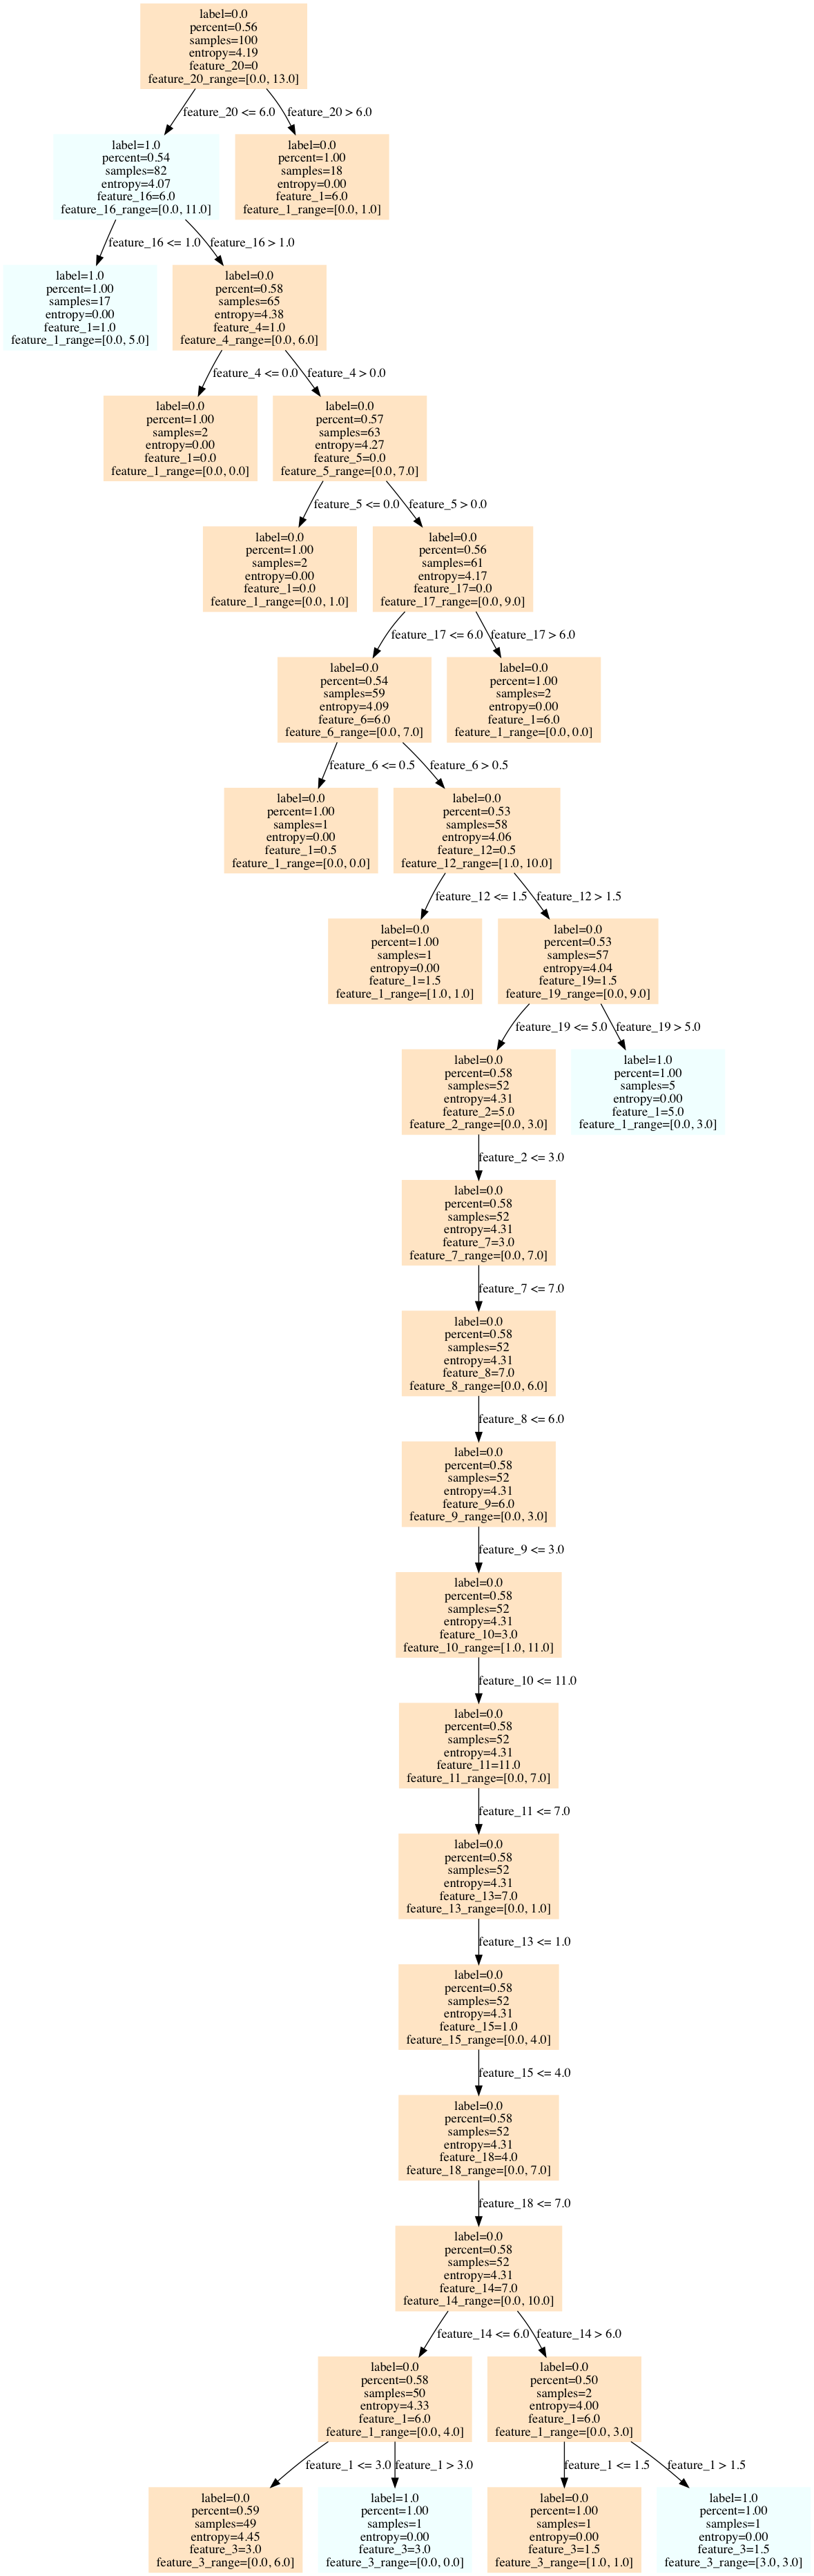

In [11]:
X, y = make_multilabel_classification(n_classes=2, n_labels=1, allow_unlabeled=False, random_state=1)
y = np.argmax(y, axis=1)
df = pd.DataFrame(np.c_[X, y], columns=['feature_{}'.format(i+1) for i in range(X.shape[1])] + ['label'])
[entropy_by_continous_feature(df.iloc[:, :-1], df.iloc[:, [-1]], i) for i in range(df.shape[1]-1)], entropy(df.iloc[:, -1].values)
tree = build_id3(df, 0, entropy_by_continous_feature)
plot_tree(tree, {1: 'azure', 0:'bisque'})

In [12]:
x=df.iloc[0, :-1]
x, tree.predict(x)

(feature_1     3.0
 feature_2     0.0
 feature_3     2.0
 feature_4     1.0
 feature_5     6.0
 feature_6     2.0
 feature_7     3.0
 feature_8     4.0
 feature_9     0.0
 feature_10    6.0
 feature_11    2.0
 feature_12    7.0
 feature_13    0.0
 feature_14    7.0
 feature_15    3.0
 feature_16    3.0
 feature_17    0.0
 feature_18    1.0
 feature_19    8.0
 feature_20    3.0
 Name: 0, dtype: float64, 0.0)

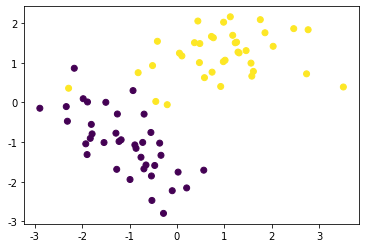

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, 
                           n_repeated=0, n_classes=2, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)
df = pd.DataFrame(np.c_[X_train, y_train], columns=['feature_1', 'feature_2', 'label'])

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

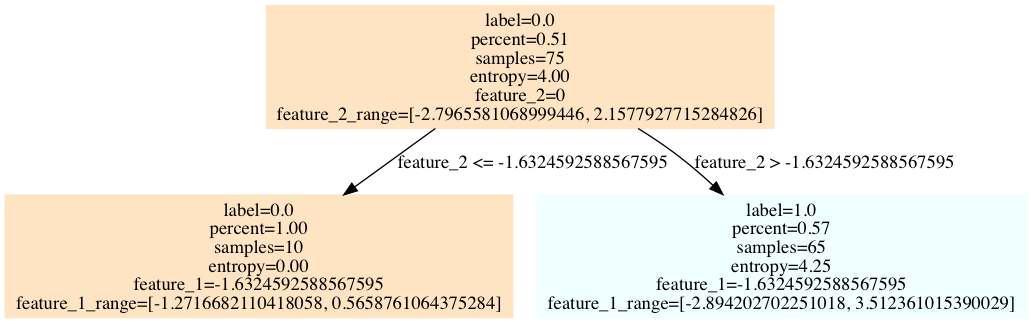

In [14]:
tree = build_id3(df, 0, entropy_by_continous_feature)
plot_tree(tree, {1: 'azure', 0:'bisque'})

Text(0.5, 1.0, 'Accuracy: 0.64')

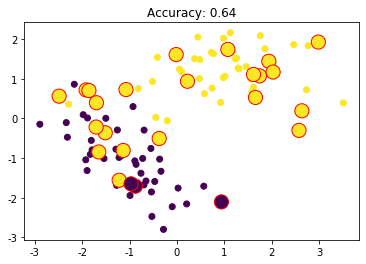

In [15]:
from sklearn.metrics import accuracy_score
ypred = [tree.predict(x) for x in X_test]
score = accuracy_score(ypred, y_test)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.scatter(X_test[:, 0], X_test[:, 1], c=ypred, s=200, ec='r')
plt.title('Accuracy: {:.2f}'.format(score))